In [1]:
%matplotlib inline

In [2]:
import sys

In [3]:
import uproot
import numpy as np
import pandas
import awkward

import plotly.graph_objects as go
import vector

import matplotlib.pyplot as plt

In [18]:
def hits_to_features(hit_data, iev, coll, feats):
    
    if "TrackerHit" in coll:
        new_feats = []
        for feat in feats:
            feat_to_get = feat
            if feat == "energy":
                feat_to_get = "eDep"
            new_feats.append((feat, feat_to_get))
    else:
        new_feats = [(f, f) for f in feats]
        
    feat_arr = {f1: hit_data[coll + "." + f2][iev] for f1, f2 in new_feats}

    sdcoll = "subdetector"
    feat_arr[sdcoll] = np.zeros(len(feat_arr["type"]), dtype=np.int32)
    if coll.startswith("ECAL"):
        feat_arr[sdcoll][:] = 0
    elif coll.startswith("HCAL"):
        feat_arr[sdcoll][:] = 1
    elif coll.startswith("MUON"):
        feat_arr[sdcoll][:] = 2
    else:
        feat_arr[sdcoll][:] = 3
    return awkward.Record(feat_arr)

In [19]:
fi = uproot.open("../data/clic_edm4hep_2023_02_27/p8_ee_tt_ecm380/rootfiles/reco_p8_ee_tt_ecm380_1.root")
ev = fi["events"]

In [20]:
pdg_dict = {
    22: "photon",  # photon    
    11: "lepton",     # electron
    12: "neutrino",     # electron neutrino  
    13: "lepton",     # muon
    14: "neutrino",     # muon neutrino 
    130: "n. hadron",      # strange meson (neutral hadron)
    2112: "n. hadron",    # n (neutral hadron)    
    211: "ch. hadron",   # pi+ (charged hadron)
    321: "ch. hadron",    # K+ (charged hadron)
    2212: "ch. hadron",   # proton (charged hadron) 
    -1: "",
}

# Raw hits

In [102]:
iev = 4

collectionIDs = {k: v for k, v in
    zip(fi.get("metadata").arrays("CollectionIDs")["CollectionIDs"]["m_names"][0],
    fi.get("metadata").arrays("CollectionIDs")["CollectionIDs"]["m_collectionIDs"][0])}
collectionIDs_reverse = {v: k for k, v in collectionIDs.items()}

hit_data = {
    "VXDTrackerHits": ev["VXDTrackerHits"].array(),
    "VXDEndcapTrackerHits": ev["VXDEndcapTrackerHits"].array(),
    "ITrackerHits": ev["ITrackerHits"].array(),
    "OTrackerHits": ev["OTrackerHits"].array(),
    "ECALBarrel": ev["ECALBarrel"].array(),
    "ECALEndcap": ev["ECALEndcap"].array(),
    "ECALOther": ev["ECALOther"].array(),
    "HCALBarrel": ev["HCALBarrel"].array(),
    "HCALEndcap": ev["HCALEndcap"].array(),
    "HCALOther": ev["HCALOther"].array(),
    "MUON": ev["MUON"].array(),
}
    
feats = ["position.x", "position.y", "position.z", "energy", "type"]

hit_feature_matrix = []
for col in sorted(hit_data.keys()):
    icol = collectionIDs[col]
    hit_features = hits_to_features(hit_data[col], iev, col, feats)
    hit_feature_matrix.append(hit_features)
    
hit_feature_matrix = awkward.Record({
    k: awkward.concatenate([hit_feature_matrix[i][k] for i in range(len(hit_feature_matrix))]) for k in hit_feature_matrix[0].fields})

##############

df = pandas.DataFrame()
df["px"] = hit_feature_matrix["position.x"].to_numpy()
df["py"] = hit_feature_matrix["position.y"].to_numpy()
df["pz"] = hit_feature_matrix["position.z"].to_numpy()
df["energy"] = 1000*hit_feature_matrix["energy"].to_numpy()
df["plotsize"] = 0
df["subdetector"] = hit_feature_matrix["subdetector"].to_numpy()

################

df.loc[df["subdetector"]==0, "plotsize"] = df.loc[df["subdetector"]==0, "energy"]/5
df.loc[df["subdetector"]==1, "plotsize"] = df.loc[df["subdetector"]==1, "energy"]/10
df.loc[df["subdetector"]==2, "plotsize"] = df.loc[df["subdetector"]==2, "energy"]*100
df.loc[df["subdetector"]==3, "plotsize"] = df.loc[df["subdetector"]==3, "energy"]*100

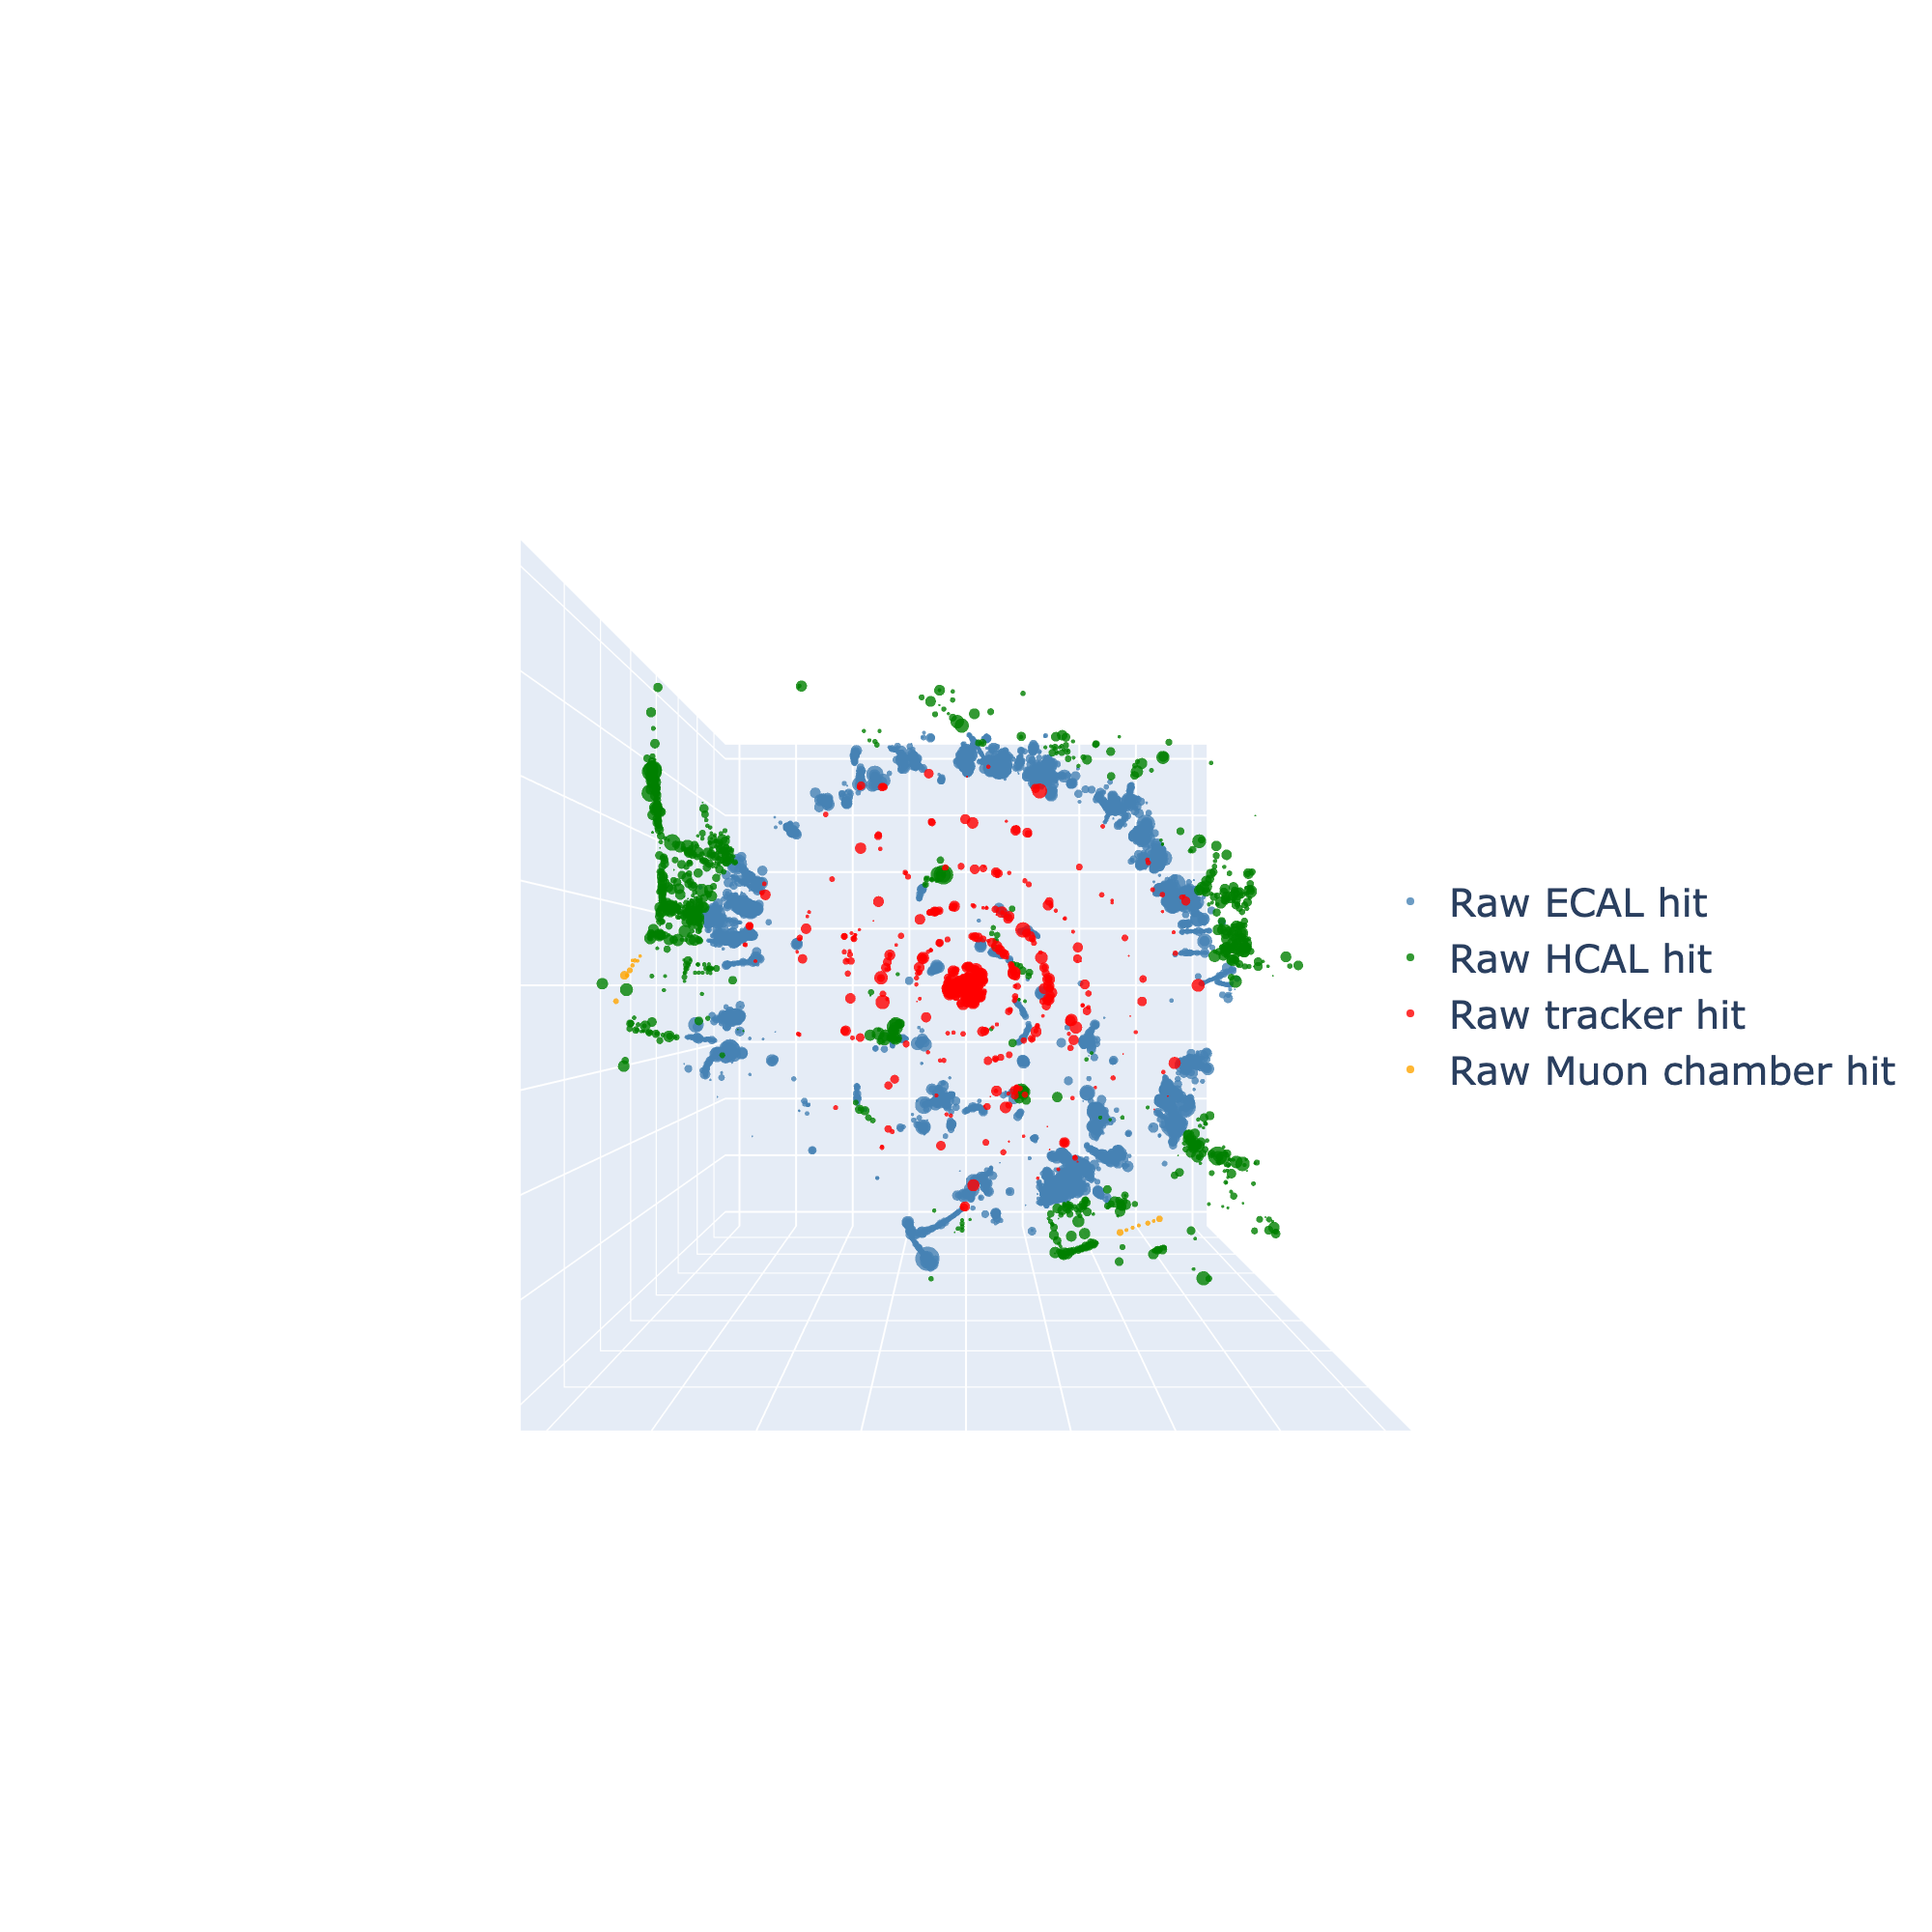

In [103]:
labels = {
    0: "Raw ECAL hit",
    1: "Raw HCAL hit",
    2: "Raw Muon chamber hit",
    3: "Raw tracker hit"
}

subdetector_color = {
    0: "steelblue",
    1: "green",
    2: "orange",
    3: "red"
}
    
    
### Create your 3D scatter plot of the raw hits

traces = []
for subdetector in df["subdetector"].unique():
    trace = go.Scatter3d(
        x=np.clip(df["px"][df["subdetector"]==subdetector], -2000, 2000),
        y=np.clip(df["py"][df["subdetector"]==subdetector], -2000, 2000),
        z=np.clip(df["pz"][df["subdetector"]==subdetector], -4000, 4000),
        mode='markers',
        marker=dict(
            size=np.clip(2+2*np.log(df["plotsize"]), 1, 15),
            color=subdetector_color[subdetector],
            colorscale='Viridis',
            opacity=0.8,
        ),
        name=labels[subdetector]
    )  

    traces.append(trace)


# Customize the axis names
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='', showticklabels=False),
        yaxis=dict(title='', showticklabels=False),
        zaxis=dict(title='', showticklabels=False),
        camera=dict(
            up=dict(x=1, y=0, z=0),  # Sets the orientation of the camera
            center=dict(x=0, y=0, z=0),  # Sets the center point of the plot
            eye=dict(x=0, y=0, z=2.5)  # Sets the position of the camera
        )
    ),
    legend=dict(x=0.75, y=0.5, font = dict(size = 20)),  # https://plotly.com/python/legend/
    showlegend=True,
)

# Create the figure and display the plot
fig = go.Figure(data=traces, layout=layout)

fig.update_traces(marker_line_width=0, selector=dict(type='scatter3d'))   # for plotly to avoid plotting white spots when things overlap

fig.show(renderer="png", width=1000, height=1000, scale=2)
fig.write_image("pic_rawhits.pdf", width=1000, height=1000, scale=2)

# Tracks and raw calo hits

In [104]:
# borrowed from here: https://github.com/farakiko/particleflow/blob/main/fcc/postprocessing.py

track_coll = "SiTracks_Refitted"

track_feature_order = [
    "elemtype",
    "pt",
    "eta",
    "sin_phi",
    "cos_phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]

def track_pt(omega):
    a = 3 * 10**-4
    b = 4  # B-field in tesla, from clicRec_e4h_input

    return a * np.abs(b / omega)    


def track_to_features(prop_data, iev):
    track_arr = prop_data[track_coll][iev]
    feats_from_track = ["type", "chi2", "ndf", "dEdx", "dEdxError", "radiusOfInnermostHit"]
    ret = {feat: track_arr[track_coll + "." + feat] for feat in feats_from_track}
    n_tr = len(ret["type"])

    # get the index of the first track state
    trackstate_idx = prop_data[track_coll][track_coll + ".trackStates_begin"][iev]
    # get the properties of the track at the first track state (at the origin)
    for k in ["tanLambda", "D0", "phi", "omega", "Z0", "time"]:
        ret[k] = prop_data["SiTracks_1"]["SiTracks_1." + k][iev][trackstate_idx]

    ret["pt"] = track_pt(ret["omega"])
    ret["px"] = np.cos(ret["phi"]) * ret["pt"]
    ret["py"] = np.sin(ret["phi"]) * ret["pt"]
    ret["pz"] = ret["tanLambda"] * ret["pt"]
    
    ret["q"] = ret["omega"].to_numpy().copy()
    ret["q"][ret["q"]>0] = 1
    ret["q"][ret["q"]<0] = -1


    return ret["px"].to_numpy(), ret["py"].to_numpy(), ret["pz"].to_numpy(), ret["q"]

In [105]:
########### tracks

prop_data = ev.arrays([track_coll, "SiTracks_1"])
px, py, pz, charge = track_to_features(prop_data, 4)

pion_mass = ev["MCParticles/MCParticles.mass"].array()[msk_gen][iev][pdg==211][0]
mass = np.zeros_like(px) + pion_mass

B = 4.0 # magnetic field in T
c = 3e8 # speed of light in m/s
scale = 2500

mc_x, mc_y, mc_z = [], [], []
for irow in range(len(px)):
    
    # convert to vector
    v = vector.obj(
        px=px[irow],
        py=py[irow],
        pz=pz[irow],
        mass=mass[irow])
    
    # radius of the helix in m
    R = v.pt / (np.abs(charge[irow]) * 0.3 * B)
    # angular frequency
    omega = np.abs(charge[irow]) * 0.3 * B / (v.gamma * v.mass)
    # time values
    t_values = np.linspace(0, 1/(c * v.beta), 50)
    # trajectory in 3D space
    mc_x += list(scale * R * np.cos(omega * c * t_values + v.phi - np.pi/2) - scale * R * np.cos(v.phi - np.pi/2))
    mc_y += list(scale * R * np.sin(omega * c * t_values + v.phi - np.pi/2) - scale * R * np.sin(v.phi - np.pi/2))
    mc_z += list(scale * v.pz * c * t_values / (v.gamma * v.mass))
    
    mc_x += [None]
    mc_y += [None]
    mc_z += [None]

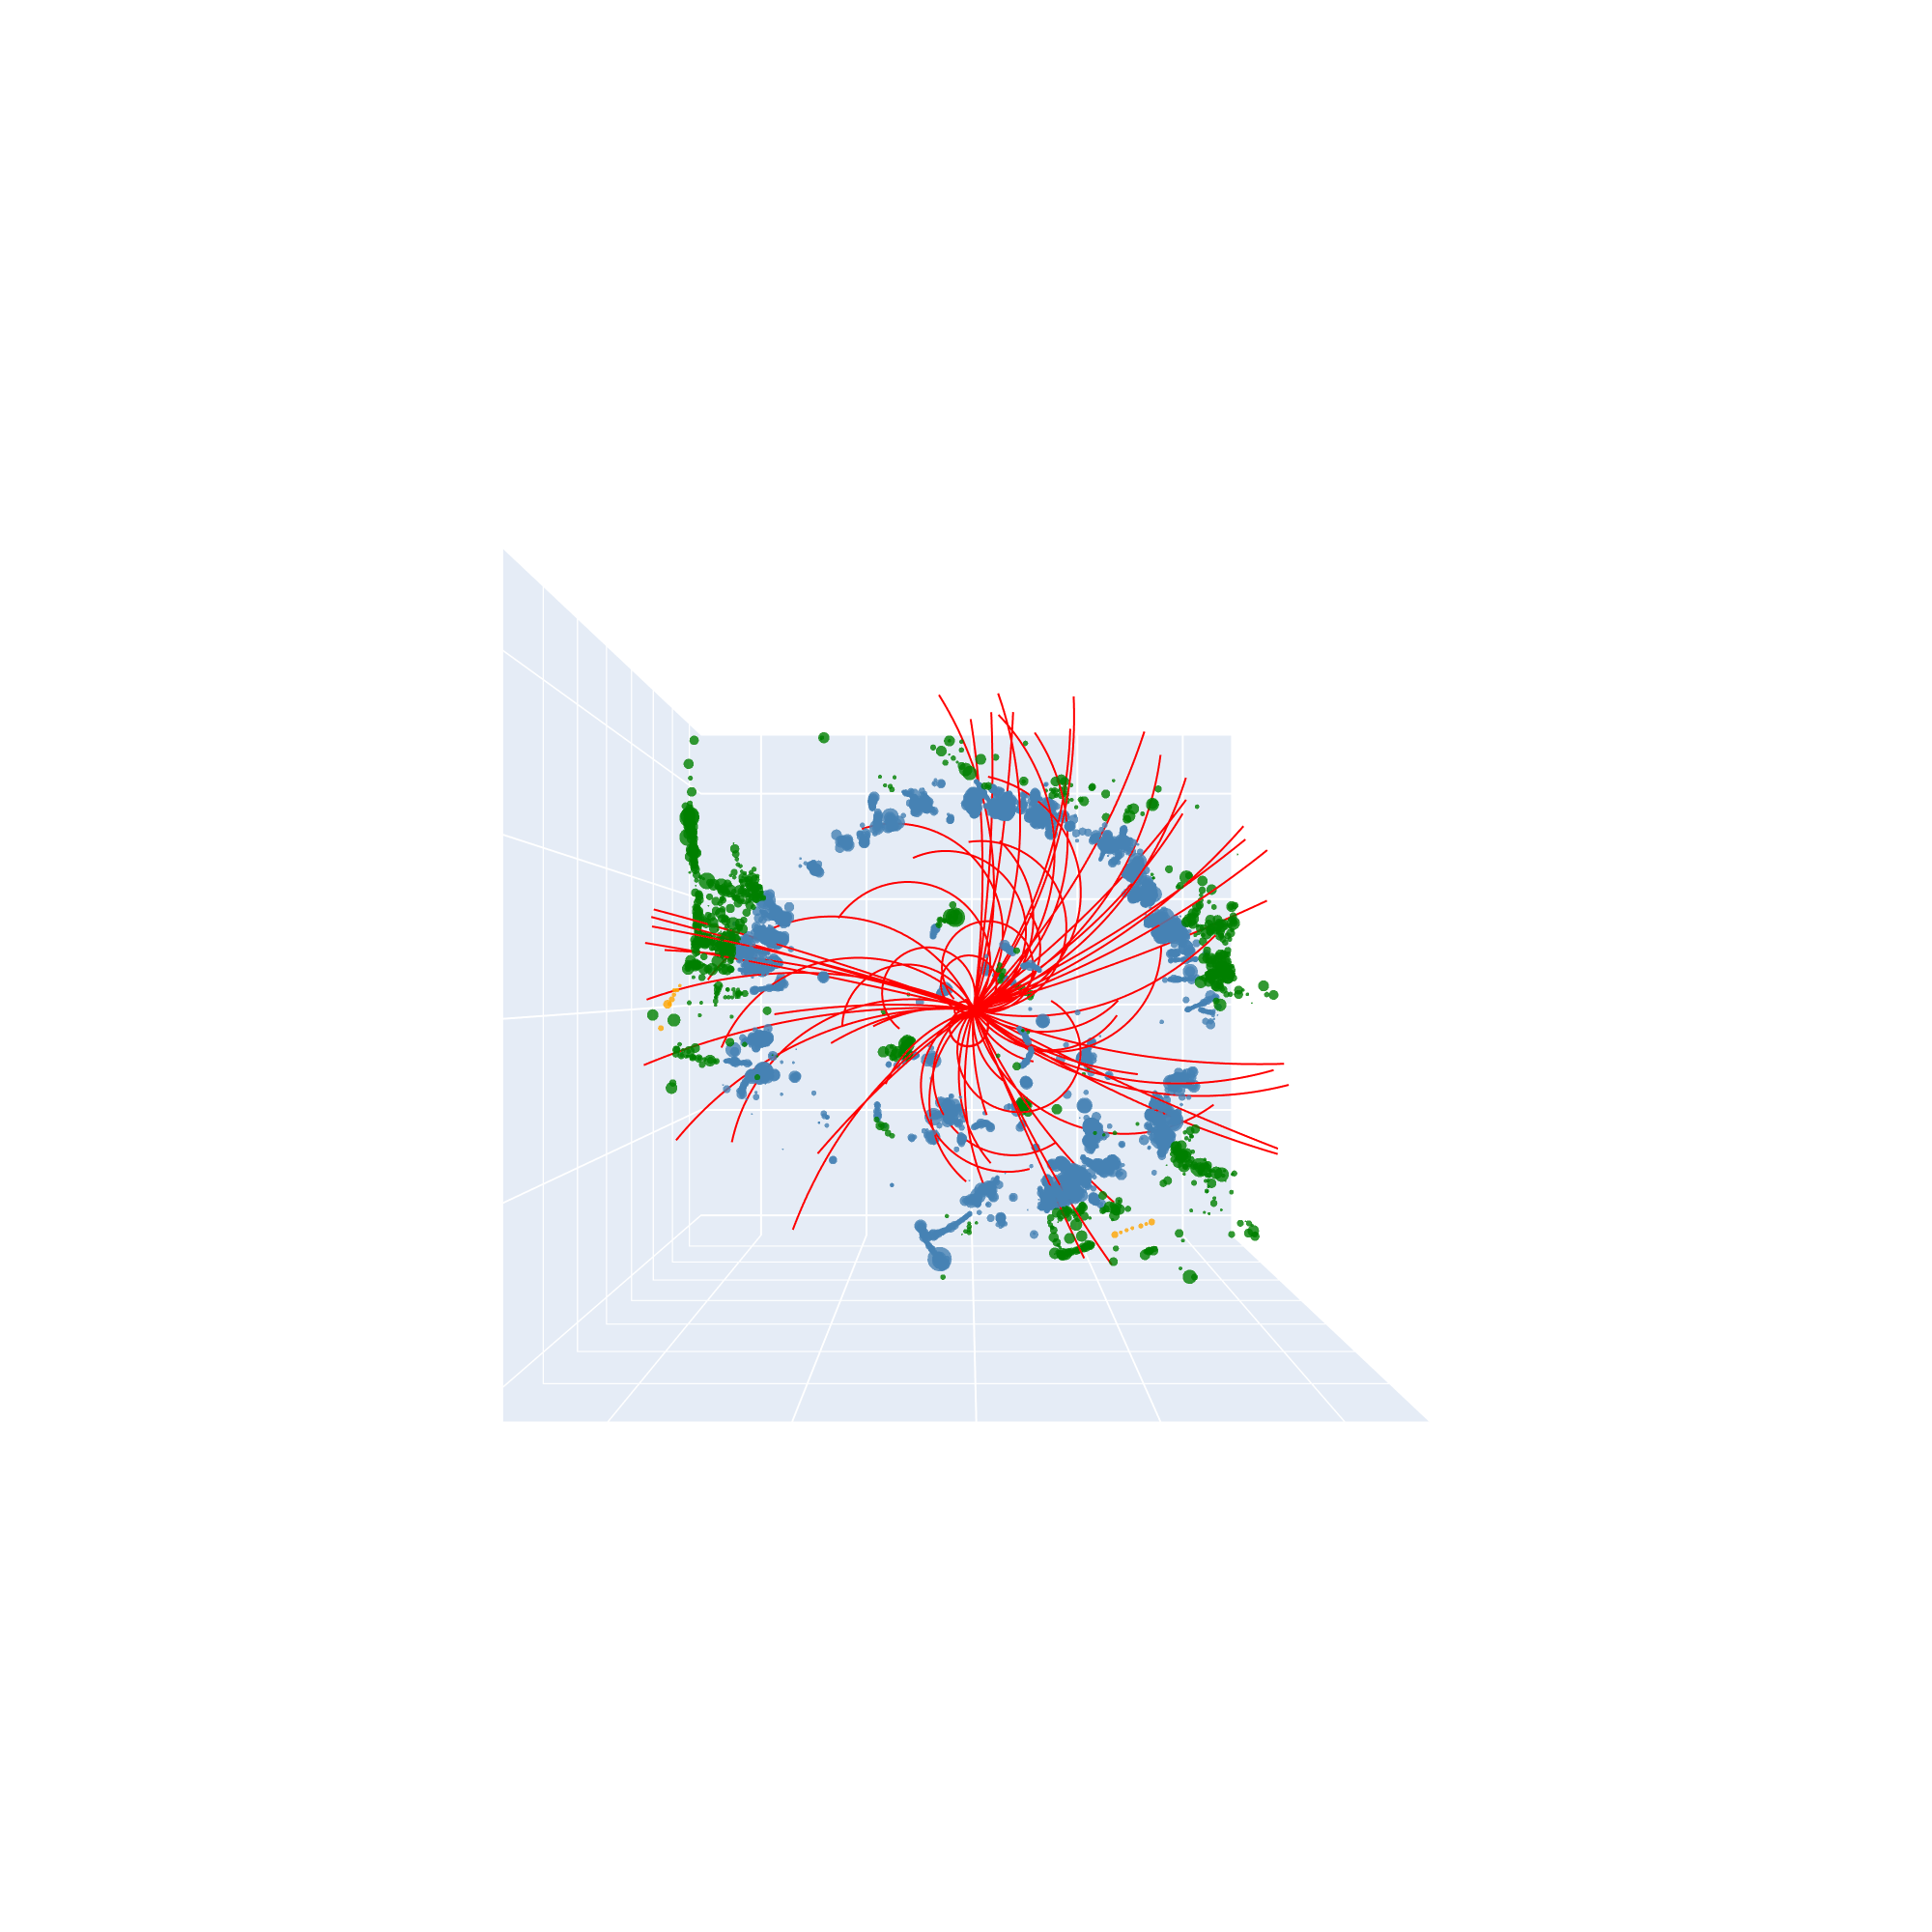

In [106]:
### Create your 3D scatter plot of the raw hits

traces = []
for subdetector in df["subdetector"].unique():

    if subdetector == 3:   # track hits
        continue
    
    trace = go.Scatter3d(
        x=np.clip(df["px"][df["subdetector"]==subdetector], -2000, 2000),
        y=np.clip(df["py"][df["subdetector"]==subdetector], -2000, 2000),
        z=np.clip(df["pz"][df["subdetector"]==subdetector], -4000, 4000),
        mode='markers',
        marker=dict(
            size=np.clip(2+2*np.log(df["plotsize"]), 1, 15),
            color=subdetector_color[subdetector],
            colorscale='Viridis',
            opacity=0.8,
        ),
        name=labels[subdetector]
    )  

    traces.append(trace)

trace = go.Scatter3d(
    x=np.array(mc_x),
    y=np.array(mc_y),
    z=np.array(mc_z),
    mode='lines',
    name="Track",
    line=dict(color="red"),
)    
traces.append(trace)

# Customize the axis names
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='', showticklabels=False),
        yaxis=dict(title='', showticklabels=False),
        zaxis=dict(title='', showticklabels=False),
        camera=dict(
            up=dict(x=1, y=0, z=0),  # Sets the orientation of the camera
            center=dict(x=0, y=0, z=0),  # Sets the center point of the plot
            eye=dict(x=0, y=0, z=2.5)  # Sets the position of the camera
        )
    ),
    legend=dict(x=0.75, y=0.5, font = dict(size = 20)),  # https://plotly.com/python/legend/
    showlegend=False,
)

# Create the figure and display the plot
fig = go.Figure(data=traces, layout=layout)

fig.update_traces(marker_line_width=0, selector=dict(type='scatter3d'))   # for plotly to avoid plotting white spots when things overlap

fig.show(renderer="png", width=1000, height=1000, scale=2)
fig.write_image("pic_tracks_rawcalohits.pdf", width=1000, height=1000, scale=2)

# Clusters and tracks

In [107]:
iev = 4

########### clusters

px = ev["PandoraClusters/PandoraClusters.position.x"].array()[iev]
py = ev["PandoraClusters/PandoraClusters.position.y"].array()[iev]
pz = ev["PandoraClusters/PandoraClusters.position.z"].array()[iev]
energy = ev["PandoraClusters/PandoraClusters.energy"].array()[iev]

cluster_x, cluster_y, cluster_z, = [], [], []
for irow in range(len(px)):
    
    # convert to vector
    v = vector.obj(
        px=px[irow],
        py=py[irow],
        pz=pz[irow],)
 
    cluster_x += [0, np.clip(scale * v.px/v.mag, -2000, 2000)]
    cluster_y += [0, np.clip(scale * v.py/v.mag, -2000, 2000)]
    cluster_z += [0, np.clip(scale * v.pz/v.mag, -4000, 4000)]
    
    cluster_x += [None]
    cluster_y += [None]
    cluster_z += [None]

    
########### tracks

prop_data = ev.arrays([track_coll, "SiTracks_1"])
px, py, pz, charge = track_to_features(prop_data, 4)

pion_mass = ev["MCParticles/MCParticles.mass"].array()[msk_gen][iev][pdg==211][0]
mass = np.zeros_like(px) + pion_mass

B = 4.0 # magnetic field in T
c = 3e8 # speed of light in m/s
scale = 2500

mc_x, mc_y, mc_z = [], [], []
for irow in range(len(px)):
    
    # convert to vector
    v = vector.obj(
        px=px[irow],
        py=py[irow],
        pz=pz[irow],
        mass=mass[irow])
    
    # radius of the helix in m
    R = v.pt / (np.abs(charge[irow]) * 0.3 * B)
    # angular frequency
    omega = np.abs(charge[irow]) * 0.3 * B / (v.gamma * v.mass)
    # time values
    t_values = np.linspace(0, 1/(c * v.beta), 50)
    # trajectory in 3D space
    mc_x += list(scale * R * np.cos(omega * c * t_values + v.phi - np.pi/2) - scale * R * np.cos(v.phi - np.pi/2))
    mc_y += list(scale * R * np.sin(omega * c * t_values + v.phi - np.pi/2) - scale * R * np.sin(v.phi - np.pi/2))
    mc_z += list(scale * v.pz * c * t_values / (v.gamma * v.mass))
    
    mc_x += [None]
    mc_y += [None]
    mc_z += [None]

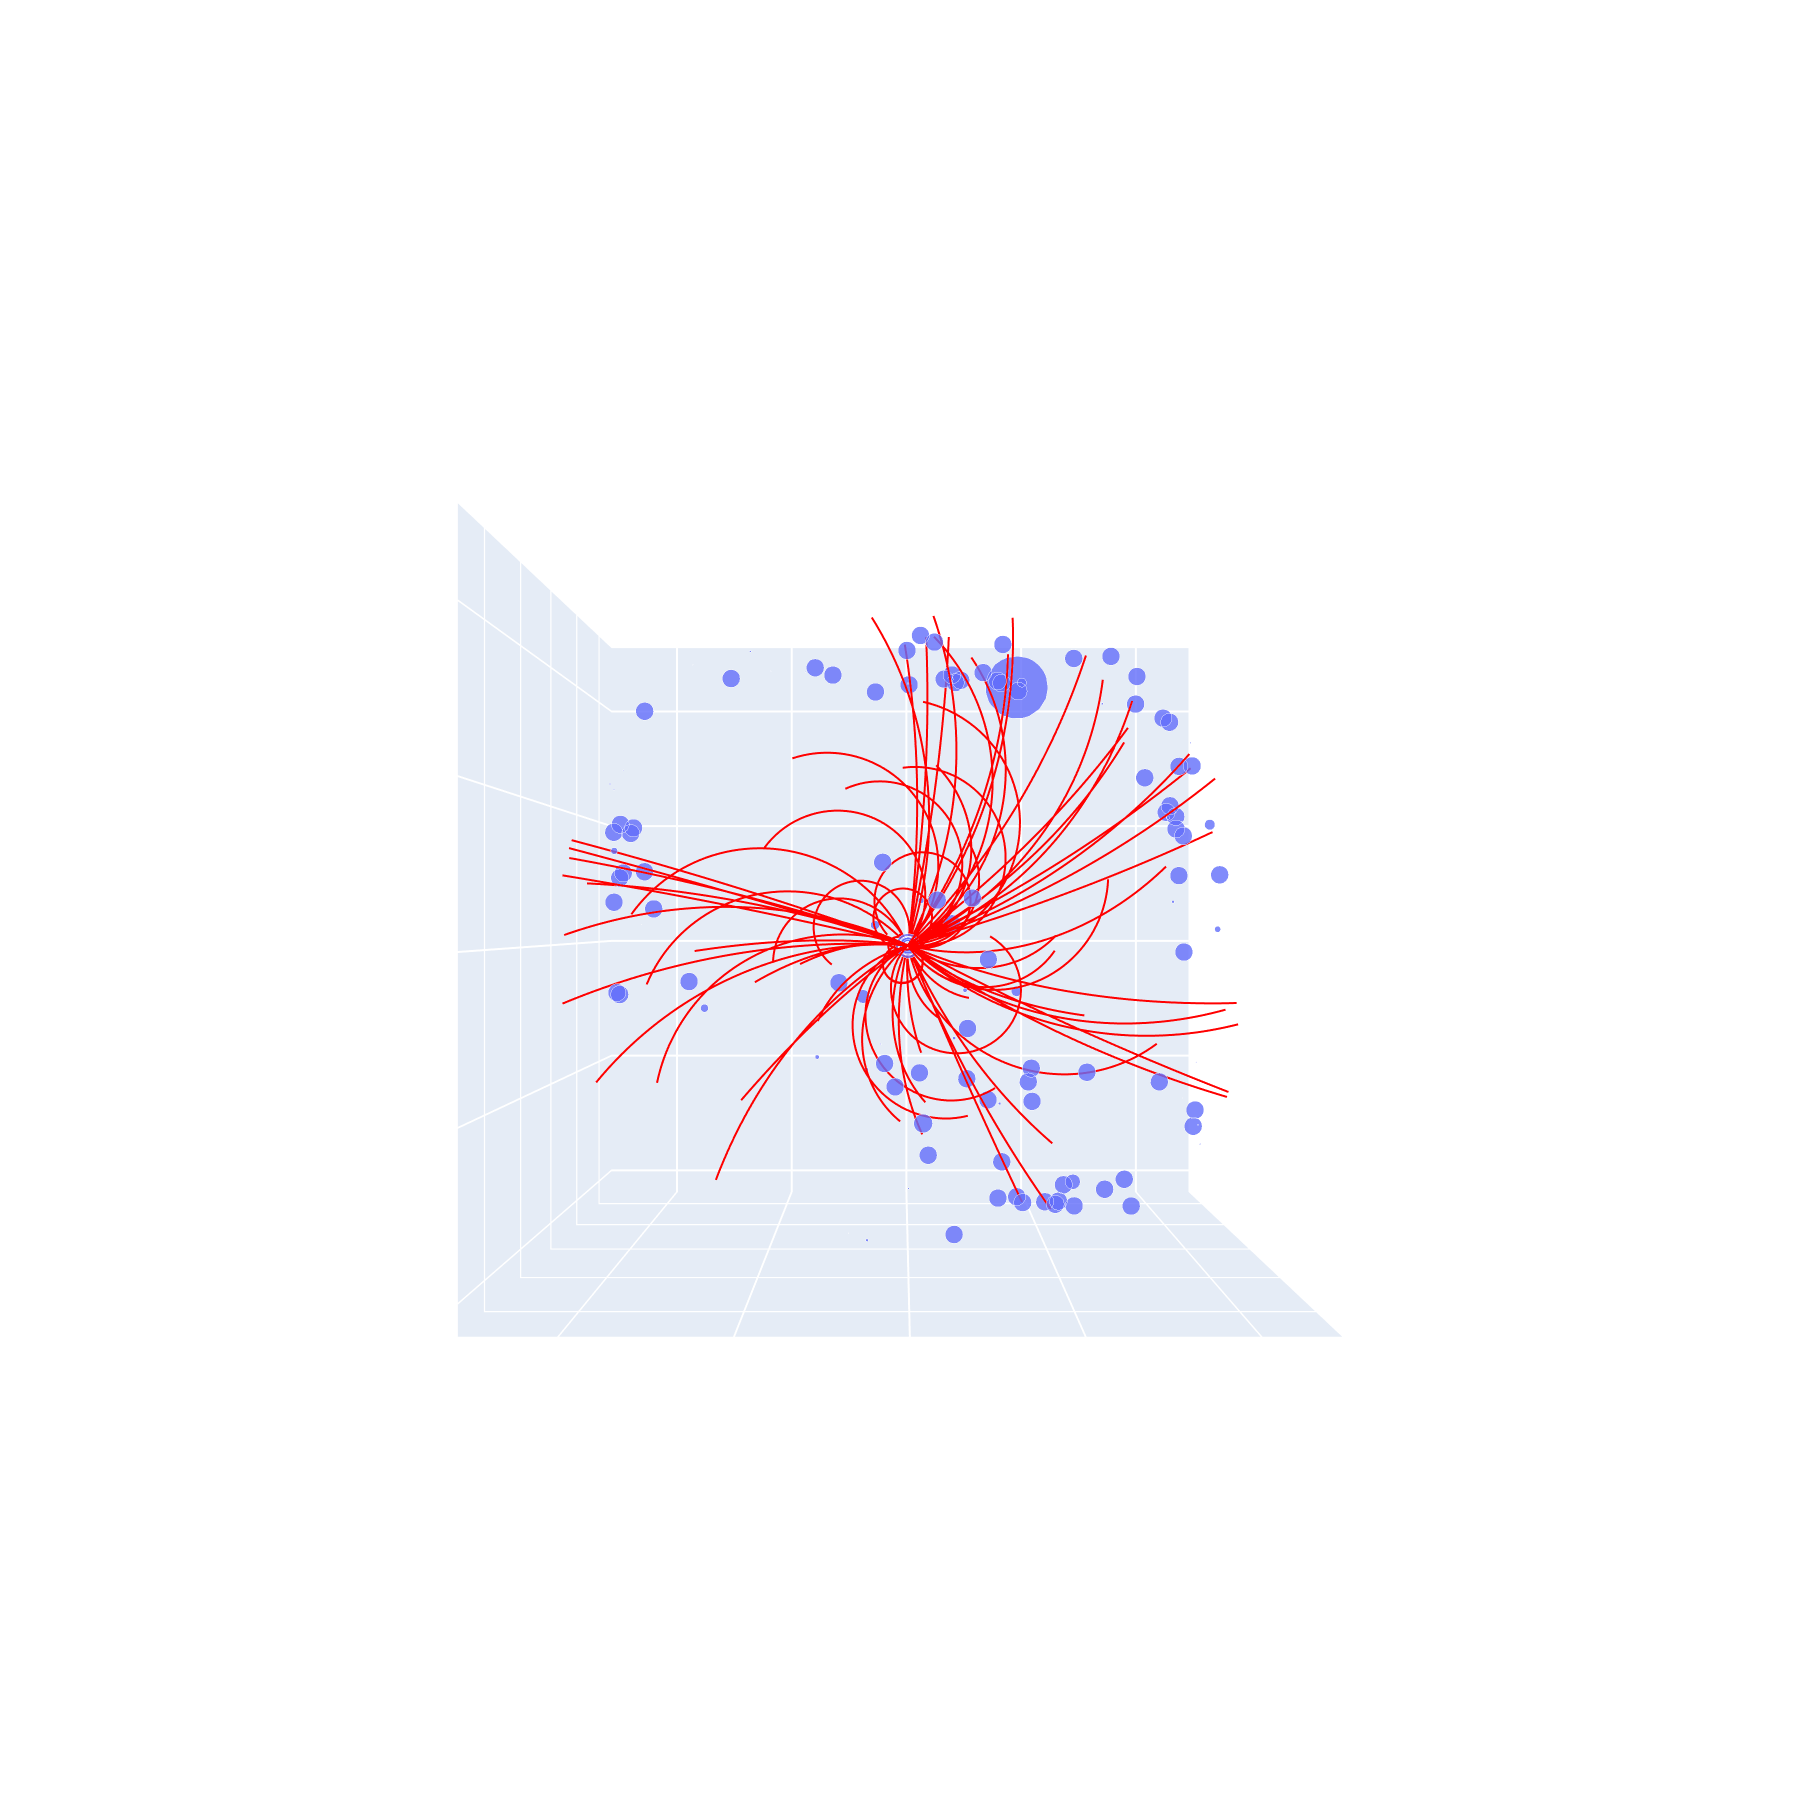

In [108]:
# cluster_color = {
    
# }

### plot the clusters
traces = []

trace = go.Scatter3d(
    x=cluster_x,
    y=cluster_y,
    z=cluster_z,
    mode='markers',
    marker=dict(
        size=energy,
        colorscale='Viridis',
        opacity=0.8,),
    name="ECAL/HCAL clusters"
)
traces.append(trace)

trace = go.Scatter3d(
    x=np.array(mc_x),
    y=np.array(mc_y),
    z=np.array(mc_z),
    mode='lines',
    name="Track",
    line=dict(color="red"),    
)    
traces.append(trace)

# Customize the axis names
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='', showticklabels=False),
        yaxis=dict(title='', showticklabels=False),
        zaxis=dict(title='', showticklabels=False),
        camera=dict(
            up=dict(x=1, y=0, z=0),  # Sets the orientation of the camera
            center=dict(x=0, y=0, z=0),  # Sets the center point of the plot
            eye=dict(x=0, y=0, z=2.5)  # Sets the position of the camera            
        )
    ),
#     legend=dict(x=0.8, y=0.5, font = dict(size = 20)),  # Adjust the legend position as needed
    showlegend=False,      
)


# Create the figure and display the plot
fig = go.Figure(data=traces, layout=layout)

fig.show(renderer="png", width=900, height=900, scale=2)
fig.write_image("pic_tracks_and_clusters.pdf", width=900, height=900, scale=2)

# Particles

In [74]:
iev = 4

###########

msk_gen = ev["MCParticles/MCParticles.generatorStatus"].array()==1

px = ev["MCParticles/MCParticles.momentum.x"].array()[msk_gen][iev]
py = ev["MCParticles/MCParticles.momentum.y"].array()[msk_gen][iev]
pz = ev["MCParticles/MCParticles.momentum.z"].array()[msk_gen][iev]
mass = ev["MCParticles/MCParticles.mass"].array()[msk_gen][iev]
charge = ev["MCParticles/MCParticles.charge"].array()[msk_gen][iev]
pdg = np.absolute(ev["MCParticles/MCParticles.PDG"].array()[msk_gen][iev])

###########

B = 4.0 # magnetic field in T
c = 3e8 # speed of light in m/s
scale = 2500

mc_x = []
mc_y = []
mc_z = []
pdg_list = []
for irow in range(len(px)):
    
    this_mc_x = []
    this_mc_y = []
    this_mc_z = []
    
    # convert to vector
    v = vector.obj(
        px=px[irow],
        py=py[irow],
        pz=pz[irow],
        mass=mass[irow])
    if charge[irow] == 0:
        # pass
        this_mc_x += [0, np.clip(scale * v.px/v.mag, -2000, 2000)]
        this_mc_y += [0, np.clip(scale * v.py/v.mag, -2000, 2000)]
        this_mc_z += [0, np.clip(scale * v.pz/v.mag, -4000, 4000)]
    else:
        # radius of the helix in m
        R = v.pt / (np.abs(charge[irow]) * 0.3 * B)
        # angular frequency
        omega = np.abs(charge[irow]) * 0.3 * B / (v.gamma * v.mass)
        # time values
        t_values = np.linspace(0, 1/(c * v.beta), 50)
        # trajectory in 3D space
        this_mc_x += list(scale * R * np.cos(omega * c * t_values + v.phi - np.pi/2) - scale * R * np.cos(v.phi - np.pi/2))
        this_mc_y += list(scale * R * np.sin(omega * c * t_values + v.phi - np.pi/2) - scale * R * np.sin(v.phi - np.pi/2))
        this_mc_z += list(scale * v.pz * c * t_values / (v.gamma * v.mass))
        
    pdg_list += len(this_mc_x) * [pdg_dict[pdg[irow]]]
        
    mc_x += this_mc_x
    mc_y += this_mc_y
    mc_z += this_mc_z
    
    mc_x += [None]
    mc_y += [None]
    mc_z += [None]
    pdg_list += [pdg_dict[-1]]
    
pdg_list = np.array(pdg_list)

In [75]:
"""
colors in plotly
#######
aliceblue, antiquewhite, aqua, aquamarine, azure, beige, bisque, black, blanchedalmond, blue,
blueviolet, brown, burlywood, cadetblue, chartreuse, chocolate, coral, cornflowerblue,
cornsilk, crimson, cyan, darkblue, darkcyan, darkgoldenrod, darkgray, darkgrey, darkgreen,
darkkhaki, darkmagenta, darkolivegreen, darkorange, darkorchid, darkred, darksalmon, darkseagreen,
darkslateblue, darkslategray, darkslategrey, darkturquoise, darkviolet, deeppink, deepskyblue,
dimgray, dimgrey, dodgerblue, firebrick, floralwhite, forestgreen, fuchsia, gainsboro,
ghostwhite, gold, goldenrod, gray, grey, green, greenyellow, honeydew, hotpink, indianred, indigo,
ivory, khaki, lavender, lavenderblush, lawngreen, lemonchiffon, lightblue, lightcoral, lightcyan,
lightgoldenrodyellow, lightgray, lightgrey, lightgreen, lightpink, lightsalmon, lightseagreen,
lightskyblue, lightslategray, lightslategrey, lightsteelblue, lightyellow, lime, limegreen,
linen, magenta, maroon, mediumaquamarine, mediumblue, mediumorchid, mediumpurple,
mediumseagreen, mediumslateblue, mediumspringgreen, mediumturquoise, mediumvioletred, midnightblue,
mintcream, mistyrose, moccasin, navajowhite, navy, oldlace, olive, olivedrab, orange, orangered,
orchid, palegoldenrod, palegreen, paleturquoise, palevioletred, papayawhip, peachpuff, peru, pink,
plum, powderblue, purple, red, rosybrown, royalblue, rebeccapurple, saddlebrown, salmon,
sandybrown, seagreen, seashell, sienna, silver, skyblue, slateblue, slategray, slategrey, snow, springgreen, 
steelblue, tan, teal, thistle, tomato, turquoise, violet, wheat, white, whitesmoke, yellow, yellowgreen
"""

color_dict = {
    "photon": "orange",  # photon    
    "lepton": "chocolate",     # electron
    "neutrino": "chocolate",     # electron neutrino  
    "lepton": "chocolate",     # muon
    "neutrino": "chocolate",     # muon neutrino 
    "n. hadron": "green",      # strange meson (neutral hadron)
    "n. hadron": "green",    # n (neutral hadron)    
    "ch. hadron": "blue",   # pi+ (charged hadron)
    "ch. hadron": "blue",    # K+ (charged hadron)
    "ch. hadron": "blue",   # proton (charged hadron)
    "": "chocolate"
}

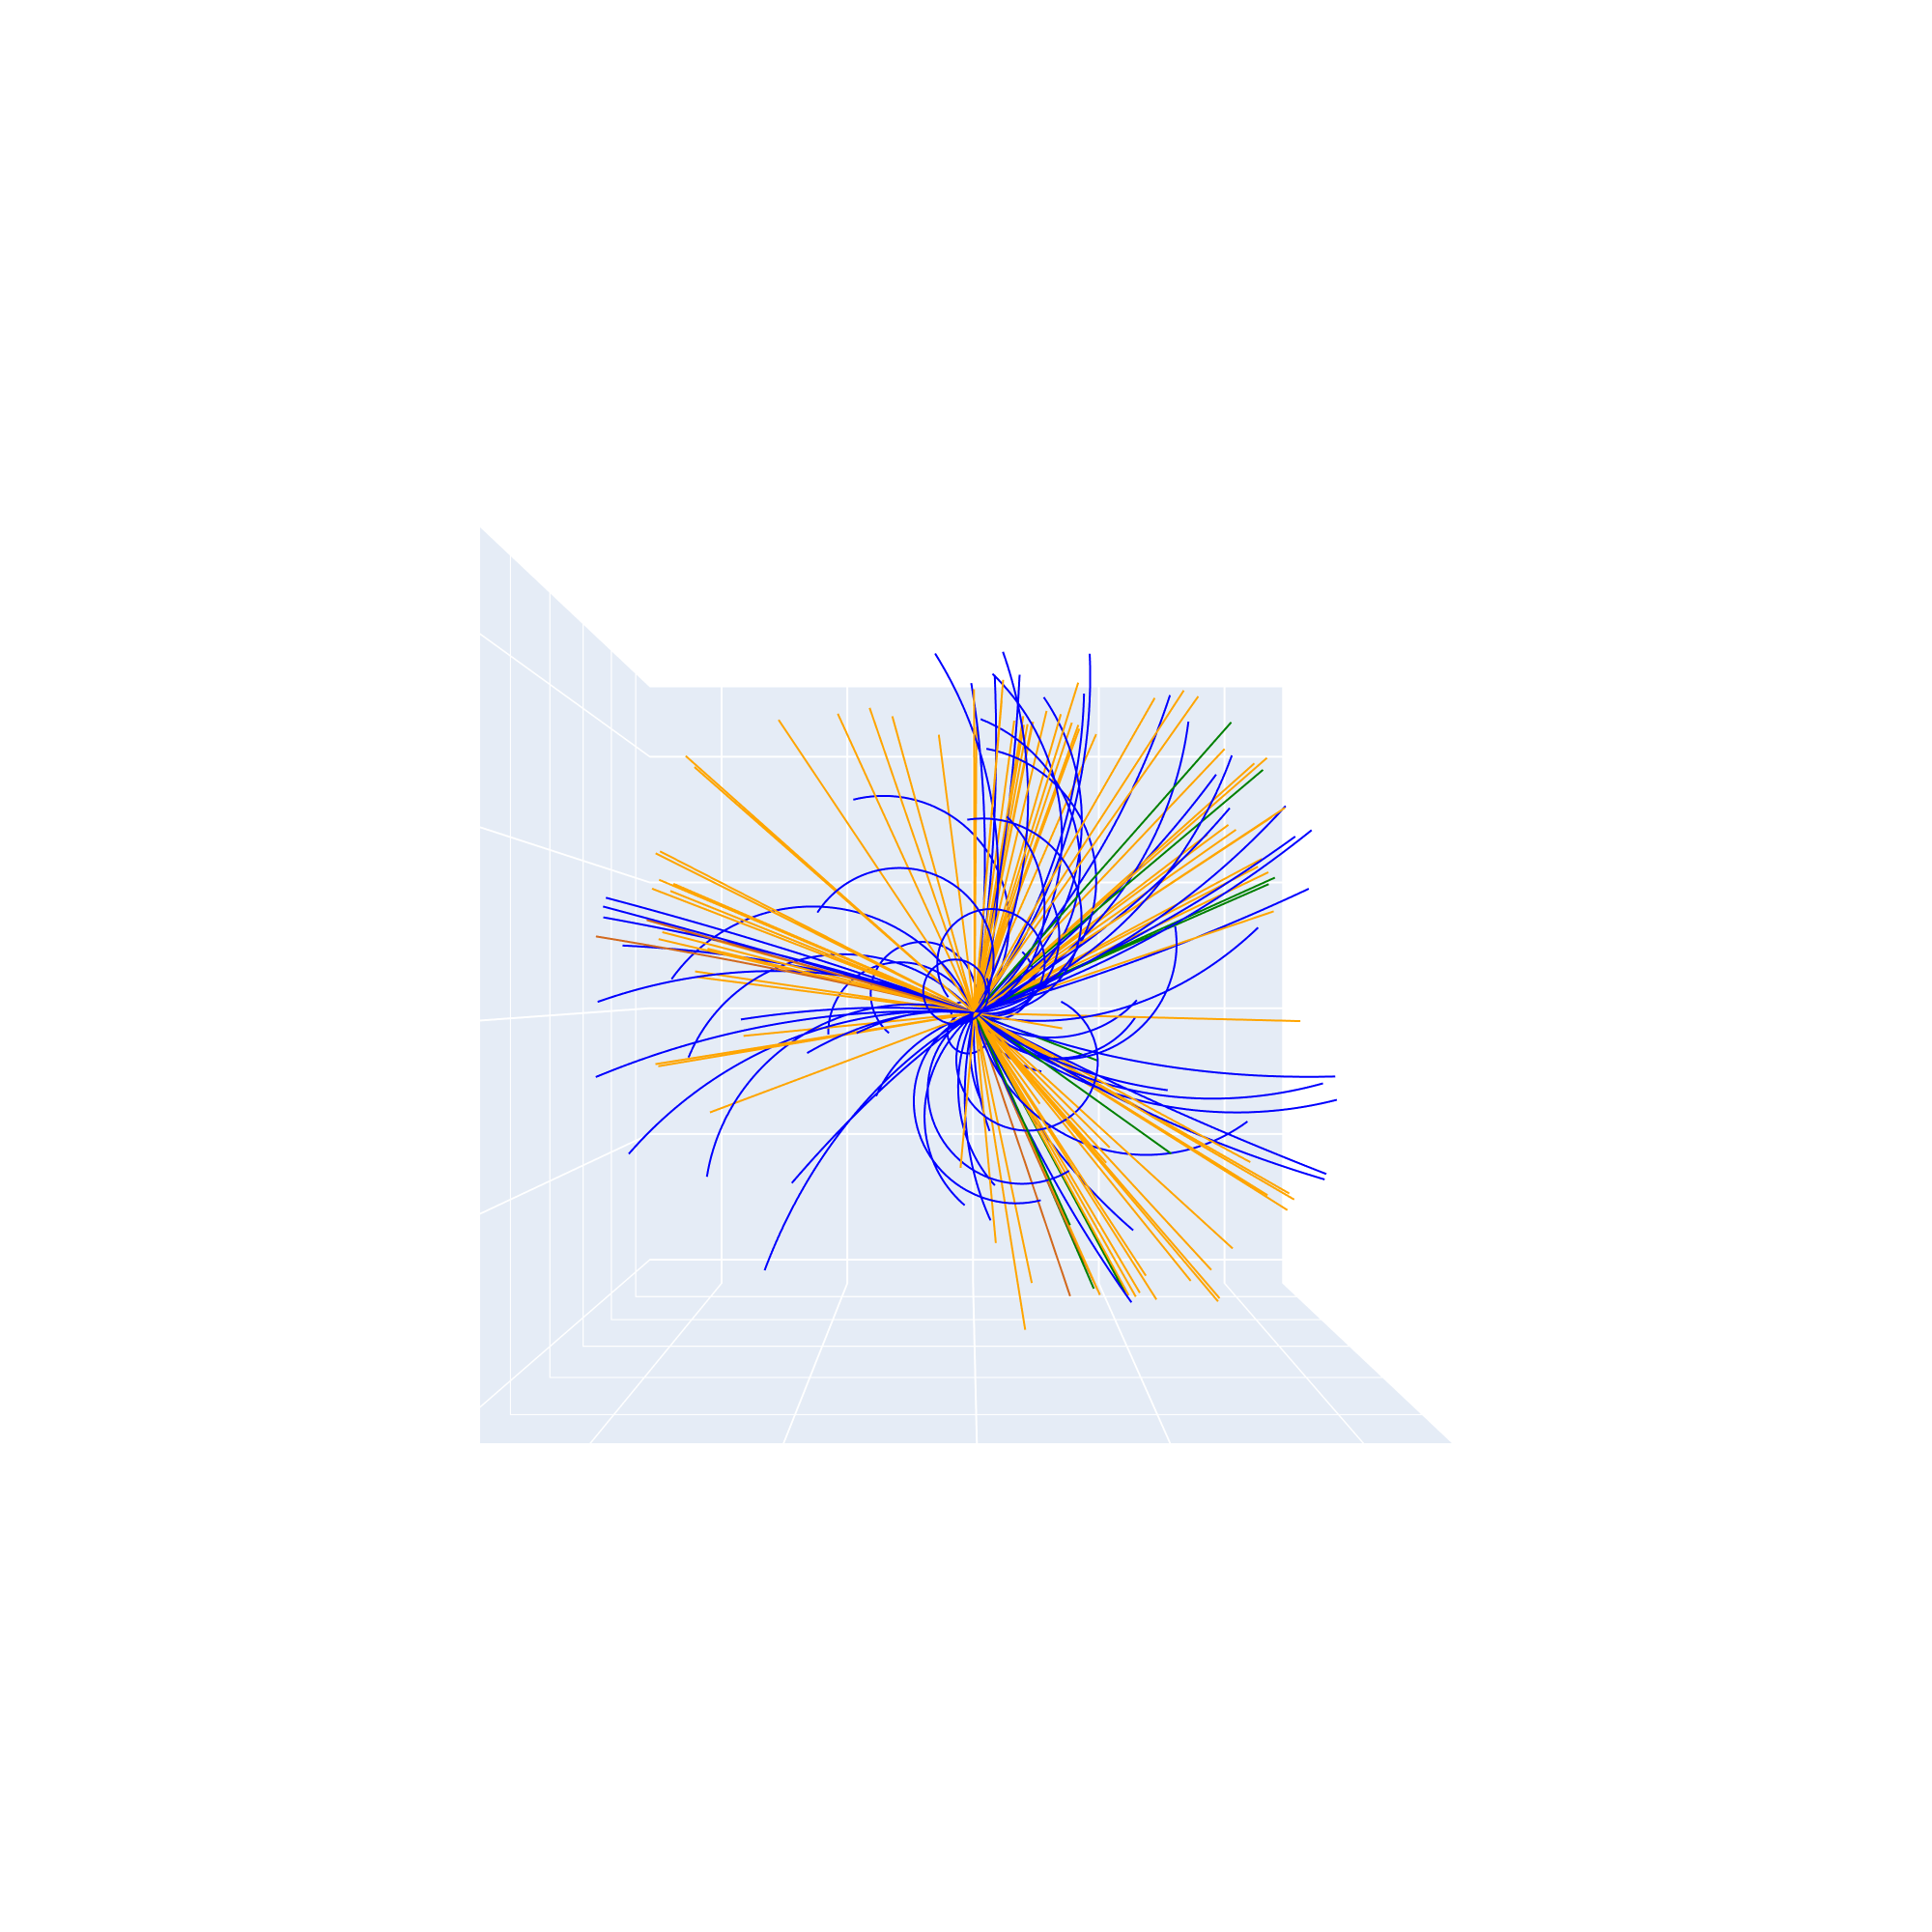

In [77]:
### Create your 3D scatter plot of the particles

trace = go.Scatter3d(
    x=np.array(mc_x),
    y=np.array(mc_y),
    z=np.array(mc_z),
    mode='lines',
    line=dict(color=[color_dict[p] for p in pdg_list]),
)    
    
# Customize the axis names
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='', showticklabels=False),
        yaxis=dict(title='', showticklabels=False),
        zaxis=dict(title='', showticklabels=False),
        camera=dict(
            up=dict(x=1, y=0, z=0),  # Sets the orientation of the camera
            center=dict(x=0, y=0, z=0),  # Sets the center point of the plot
            eye=dict(x=0, y=0, z=2.5)  # Sets the position of the camera          
            
        ),
    
    ),
    showlegend=False
)

# Create the figure and display the plot
fig = go.Figure(data=trace, layout=layout)

fig.show(renderer="png", width=1000, height=1000, scale=2)
fig.write_image("pic_particles.pdf", width=1000, height=1000, scale=2)


# #################################
# # to show legend must skip the None
# traces = []
# for particle in np.unique(pdg_list):

#     if particle in ["ch. hadron", "photon", "n. hadron"]:
#         trace = go.Scatter3d(
#             x=np.array(mc_x)[pdg_list==particle],
#             y=np.array(mc_y)[pdg_list==particle],
#             z=np.array(mc_z)[pdg_list==particle],
#             mode='lines',
#             line=dict(color=color_dict[particle]),
#             name=particle
#         )
#         traces.append(trace)
    
# # Customize the axis names
# layout = go.Layout(
#     scene=dict(
#         xaxis=dict(title='', showticklabels=False),
#         yaxis=dict(title='', showticklabels=False),
#         zaxis=dict(title='', showticklabels=False),
#         camera=dict(
#             up=dict(x=1, y=0, z=0),  # Sets the orientation of the camera
#             center=dict(x=0, y=0, z=0),  # Sets the center point of the plot
#             eye=dict(x=0, y=0, z=2.5)  # Sets the position of the camera          
            
#         ),
    
#     ),
#     legend=dict(x=0.75, y=0.5, font = dict(size = 20)),  # Adjust the legend position as needed
#     showlegend=True,    
# )

# # Create the figure and display the plot
# fig = go.Figure(data=traces, layout=layout)

# fig.show(renderer="png", width=1000, height=1000, scale=2)
# fig.write_image("pic_particles.pdf", width=1000, height=1000, scale=2)